In [57]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# set theme
sns.set_theme(
    context="paper",
    style="whitegrid",
    rc={
        "figure.figsize": (7.0, 3.5),
        "savefig.dpi": 300,
        "figure.autolayout": True,
    },
)


fig_path = Path("../figures")

file = "scalability.parquet"

# Load Data

In [58]:
data = pd.read_parquet(fig_path / file)
data

,trial,step,reward,coverage,collisions,near_collisions,n_agents,width,area,agent_radius,agent_margin
0,0,0,0.000051,0.000,0,1,20,10.0,100.0,0.1,0.1
1,0,1,0.000133,0.000,0,0,20,10.0,100.0,0.1,0.1
2,0,2,0.000282,0.000,0,0,20,10.0,100.0,0.1,0.1
3,0,3,0.000272,0.000,0,0,20,10.0,100.0,0.1,0.1
4,0,4,0.000304,0.000,0,0,20,10.0,100.0,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
1995,9,195,0.684868,0.960,0,4,500,10.0,100.0,0.1,0.1
1996,9,196,0.681677,0.962,0,4,500,10.0,100.0,0.1,0.1
1997,9,197,0.688576,0.960,0,4,500,10.0,100.0,0.1,0.1
1998,9,198,0.676389,0.964,0,4,500,10.0,100.0,0.1,0.1


# Plot

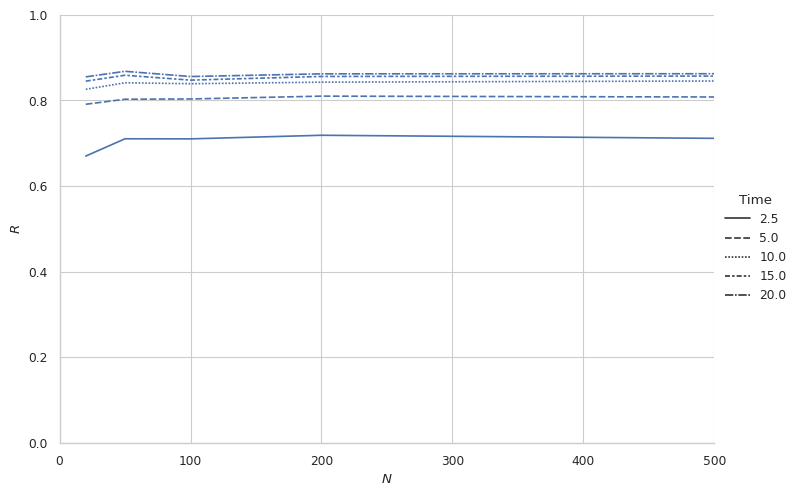

In [59]:
# Create the line plot
crosssections = pd.concat(
    [data[data["step"] == 24],
    data[data["step"] == 49],
    data[data["step"] == 99],
    data[data["step"] == 149],
    data[data["step"] == 199],]
)
crosssections["step"] += 1
crosssections["Time"] = crosssections["step"] * 0.1
crosssections = crosssections.groupby(["n_agents", "step"]).mean()

sns.relplot(
    data=crosssections,
    x="n_agents",
    y="coverage",
    # hue="step",
    style="Time",
    kind="line",
    errorbar="se",
    aspect=1.5,
)
plt.xlabel("$N$")
plt.xlim(0, 500)
plt.ylabel("$R$")
plt.ylim(0, 1)

# Save the plot
plt.savefig(fig_path / "coverage_transfer_final_scaled.png")
plt.savefig(fig_path / "coverage_transfer_final_scaled.pdf")
plt.show()